In [339]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


Goal:
Clean survey dataset
- unify commata to decimals
- clean columns from typos
- define correct datatype to the columns
- select columns which could be later needed for model development
- combine targets based on compared damage variables and flood times


For reasons of reusability and comparability the workflow of the data preprocessing was kept similar to previous preprocessings of the same questionnaire. This was achieved by dealing with missing or erroneous values in a similar way likewise erroneous values with commas or points in the beginning were converted to decimal numbers beginning with zero. 

In [340]:
import sys, os

import numpy as np
import pandas as pd
import geopandas as gpd
import re

import matplotlib.pyplot as plt
import seaborn as sns


sys.path.insert(0, "../")
#sys.path.insert(0,os.getcwd())
import utils.utils_figures as f
from utils.utils_processing import drop_object_columns, drop_typos
import utils.utils_feature_selection as fs

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [341]:
# load raw survey data

raw_data = pd.read_excel("../../input_survey_data/all-attributes_shophouses.xlsx")#, thousands=',')
raw_data.tail(3)

,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

### Overview

In [342]:
## Fix erroneous coordinate pair by removing second decimal point
raw_data.GPS = raw_data.GPS.astype(str).replace({"10.722.546,106.62888":"10.722546,106.62888",
                                     "10797626106701100":"10.797626,106.701100",  # idx 24
                                     "10722187106.63":"10.722187,106.63"})  # idx 152

In [343]:
# get coords in readable format for gpd
raw_data = gpd.GeoDataFrame(raw_data,  
            geometry=gpd.points_from_xy( 
                    raw_data["GPS"].str.split(",").str[1], # lon
                    raw_data["GPS"].str.split(",").str[0],  # lat
            )
        )
print(raw_data.shape)

## save shp locations to disk, 
# extract elevation based on shop locations in datapoints_vars_bui.shp via QGIS due to loading size and process with gdal
print(raw_data.crs)
raw_data = raw_data.set_crs(4326) 
raw_data.geometry.to_file('../../input_survey_data/DEM_LiDAR/datapoints_vars_bui.shp')  

(252, 551)
None


In [344]:
## visual check of SMEs locations

glimpse = raw_data[~ raw_data.is_empty]   # drop emtpy geoms
glimpse.geometry.explore()  


Map shows spatial distribution of business locations from the HCMC survey dataset.
It can be seen that a few shops are probably outside the admininstrative area of HCMC. 

#### Businesses outside HCMC


In [345]:
hcmc_boundary = gpd.read_file("../../input_survey_data/DEM_LiDAR/gadm36_VNM_1.shp")  # shop locations including elevation height based on original and interpolated DEM
hcmc_boundary = hcmc_boundary[hcmc_boundary.VARNAME_1 == "Ho Chi Minh"]

## clip by HCMC adminstrative boundary
raw_data_clipped = raw_data.clip(hcmc_boundary.geometry)

# fig, ax = plt.subplots(figsize=(12, 8))
# raw_data_clipped.plot(ax=ax, color="blue")
# raw_data.plot(ax=ax, color="black")
# raw_data_clipped.geometry.plot(ax=ax)
# hcmc_boundary.boundary.plot(ax=ax, color="red")
# plt.show()

##  cases outside hcmc:
shp_inside_hcmc = raw_data_clipped
shp_outside_hcmc = raw_data.merge(shp_inside_hcmc.drop_duplicates(), how='left', indicator=True)
shp_outside_hcmc = shp_outside_hcmc[shp_outside_hcmc['_merge'] == 'left_only']
shp_outside_hcmc
print("Number of shops outside HCMC:", shp_outside_hcmc.shape[0])

raw_data.loc[shp_outside_hcmc.index, :]


Number of shops outside HCMC: 2


,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

It is decided to keep these cases , one reason is that their variable values seems reasonable (i.e. both targets, hydrological and building variables), the other reason is that removing them from the dataset would shrink the moderate large dataset; as more cases, potentially the better the algorithms can be trained. 

### rename columns

All variables based on the most recent event are ending with "_r", all variables for the most serious event since 2010 are ending with "_s".
"hh" is usedas abbreviation for households, single "b" for building 



*Targets*

In [346]:
df = raw_data

# target var for direct cost on content loss [VND]
df.insert(0, "Target_contentloss_mVND_r", df.pop("P1Q5.6.1")) 
df.insert(1, "Target_contentloss_mVND_s", df.pop("P1Q5.6.2"))

# explanatory var: monthly reduction of business [%] 
df.insert(2, "Target_businessreduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "Target_businessreduction_s", df.pop("P1Q5.9.2"))



*important columns*
Including candidate predictors and features to derive certain predictors

In [347]:
## for candidate predictors: With which reason a certain candidate predictor is selected is written after # (more detailed description in master thesis)

col_names = {        'P1Q1':'flood_experience',  
                     'P1Q2.2.1':'flood_time_r', 
                     'P1Q2.2.2':'flood_time_s',
                     'P1Q2.3.1':'inundation_duration_h_r',
                     'P1Q2.3.2':'inundation_duration_h_s',
                     'P1Q2.4.1':'water_depth_cm_r',  
                     'P1Q2.4.2':'water_depth_cm_s',    
                     'P1Q2.5.1':'contaminations_r',    
                     'P1Q2.5.2':'contaminations_s',    
                     'P1Q2.6.1':'flowvelocity_r',     
                     'P1Q2.6.2':'flowvelocity_s',        
                     'P1Q2.9.1':'warning_time_h_r',   
                     'P1Q2.9.2':'warning_time_h_s',   
                     'P1Q2.10.1':'emergency_measures_r',   
                     'P1Q2.10.2':'emergency_measures_s',   
                     'P1Q2.11.1.1':'overall_problem_house_r', 
                     'P1Q2.11.2.1':'overall_problem_house_s',

                     'P1Q3.2.1':'damage_level_floor_r',
                     'P1Q3.2.2':'damage_level_floor_s',
                     'P1Q3.3.1':'damage_level_walls_r',
                     'P1Q3.3.2':'damage_level_walls_s',
                     'P1Q3.4.1':'damage_level_foundation_r',
                     'P1Q3.4.2':'damage_level_foundation_s',
                     'P1Q3.5.1':'damage_level_doors_r',
                     'P1Q3.5.2':'damage_level_doors_s',
                     'P1Q3.6.1':'damage_level_roof_r',
                     'P1Q3.6.2':'damage_level_roof_s',
                     'P1Q3.7.1':'damage_level_basement_r',
                     'P1Q3.7.2':'damage_level_basement_s',
                     'P1Q3.88.1':'damage_level_other_r',
                     'P1Q3.88.2':'damage_level_other_s',
                     
                     'P1Q3.88.1.specify':'damage_level_specify_r',
                     'P1Q3.88.2.specify':'damage_level_specify_s',
                     'P1Q3.8.1':'repair_costs_building_VND_r',
                     'P1Q3.8.2':'repair_costs_building_VND_s',
                     'P1Q3.10.1':'reason_why_not_repaired_business_r', 
                     'P1Q3.10.2':'reason_why_not_repaired_business_s',
                     'P1Q3.11.1':'repair_costs_building_complete_mVND_r',
                     'P1Q3.11.2':'repair_costs_building_complete_mVND_s',
                     'P1Q5.2.1':'shpdamage_level_furniture_r',
                     'P1Q5.3.1':'shpdamage_level_electronics_r',
                     'P1Q5.4.1':'shpdamage_level_equipment_r',
                     'P1Q5.5.1':'shpdamage_level_products_r',
                     'P1Q5.88.1':'shpdamage_level_others_r',
                     'P1Q5.2.2':'shpdamage_level_furniture_s',
                     'P1Q5.3.2':'shpdamage_level_electronics_s',
                     'P1Q5.4.2':'shpdamage_level_equipment_s',
                     'P1Q5.5.2':'shpdamage_level_products_s',
                     'P1Q5.88.2':'shpdamage_level_others_s',
                     'P1Q5.7.1':'shp_closed_d_r',
                     'P1Q5.7.2':'shp_closed_d_s',
                     'P1Q5.8.1':'shp_duration_back2normal_r',
                     'P1Q5.8.2':'shp_duration_back2normal_s',
  
                     'P2Q1.1.implement':'protect_valuables_impl',
                     'P2Q1.1.spend':'protect_valuables_VND_spnd',
                     'P2Q1.2.implement':'water_barriers_impl',
                     'P2Q1.2.spend':'water_barriers_VND_spnd',
                     'P2Q1.3.implement':'pumping_equipment_impl',
                     'P2Q1.3.spend':'pumping_equipment_VND_spnd',
                     'P2Q1.4.implement':'elevation_building_impl',
                     'P2Q1.4.spend':'elevation_building_VND_spnd',
                     'P2Q1.5.implement':'resistant_material_building_impl',
                     'P2Q1.5.spend':'resistant_material_building_VND_spnd',
                     'P2Q1.6.implement':'electricity_higher_impl',
                     'P2Q1.6.spend':'electricity_higher_VND_spnd',
                     'P2Q1.7.implement':'flood_protections_impl',
                     'P2Q1.7.spend':'flood_protections_VND_spnd',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2':'elevation_building_height_cm',
                     'P2Q3.1.1':'insurance_building_VND',
                     'P2Q3.2.1':'insurance_business_VND',
                     
                     'P3Q1.1':'resilience_city_protection',
                     'P3Q1.2':'resilience_more_future_affected',
                     'P3Q1.3':'resilience_govern_warnings_helpful',
                     'P3Q1.4':'resilience_govern_careing',
                     'P3Q1.5':'resilience_govern_careing_increases',
                     'P3Q1.6':'resilience_left_alone',
                     'P3Q1.7':'resilience_neighbor_management',
                     'P3Q2.3':'perception_who_responsible4protection',  
                     'P3Q2.4':'perception_govern_support_past',  
                     'P3Q2.5':'perception_govern_support_future',  
                     'P3Q2.6':'perception_private_economy_future',  
  
                     'P4Q1.8':'hh_education',
                     'P4Q1.10':'hh_monthly_income_cat',
                     'P4Q2.1':'b_movingin',
                     'P4Q2.2':'b_year', 
                     'P4Q2.3':'b_area',
                     'P4Q2.5':'b_value_mVND',
                     'P4Q2.4':'lu_cert',
                     'P4Q3.1':'b_material_foundation', 
                     'P4Q3.2':'b_material_floor',
                     'P4Q3.3':'b_material_wall',
                     'P4Q3.4':'b_material_roof',
                     'P4Q3.5':'b_material_doors',
                     r'P4Q3.6$':'elevation_rel2surrounding_cat', 
                     'P4Q4.2.1':'ren1',  
                     'P4Q4.2.2':'ren2', 
                     'P4Q4.4.1':'b_renovation_reasons_r',   
                     'P4Q4.4.2':'b_renovation_reasons_s', 
                     'P4Q4.5.1':'b_renovation_cost_mVND_r', 
                     'P4Q4.5.2':'b_renovation_cost_mVND_s',  

                     r'P5Q1.1$':'shp_owner',
                     'P5Q1.3':'shp_sector', 
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_cat',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_registered_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
                     'P5Q1.10':'shp_profits_last5years',
                     'P5Q1.11':'shp_risk_tolerance',
                     'P5Q1.12':'shp_monetary_resources4prevention',
}

for k, v in col_names.items():
    df.rename(columns ={ i: re.sub(k, v, i) for i in  df.columns }, inplace=True )


### Flood times 

If the month and the day of the flood time is missing only the year is selected. If only the day of a flood event is unknown it is set to the first day of the respective month.

Pandas datetime fills missing information by 01 which would change the original information e.g if only the year is known, datetime would set it to the first January of the year. Due to this reason and many incomplete dates, the flood times were kept as ojects in two possible formats: as month/day/year or as only the year 

In [348]:
## clean flood time by keeping unknown months, convert unknow days to first day of month
# a special treatment was done to keep as much time information as possible, due that many days and months are unknown, simple conversions could cause same dates for possibliy different flood events

for i, d in enumerate(df.flood_time_r):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


for i, d in enumerate(df.flood_time_s):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace("/99","/01")  # replace unknown days
      df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


## set flood times with unknown years to NAN, as well as for typos
df.flood_time_r = df.flood_time_r.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("08/20/2023", pd.NaT)


In [349]:
print("recent events for which days and months are unknown:", (df.flood_time_r.str.len()==4).sum())
print("serious events for which days and months are unknown:", (df.flood_time_s.str.len()==4).sum())

recent events for which days and months are unknown: 23
serious events for which days and months are unknown: 34


### Damage Variables

Damage variables comprises hydrological variables, emergency measures,  variables about damage levels  of contents and binary information if a building was damaged or not,


In [350]:
## Caution: compared to the Rscript further variables are included in "vars_dam" such as flood time and damae levels of business contents
vars_dam = pd.concat([df.loc[ :, "flood_time_r":"flowvelocity_r"],
                      df.loc[ :, "warning_time_h_r":"overall_problem_house_r"],
                      df.loc[ :, "shpdamage_level_furniture_r":"shpdamage_level_products_r"],
                      df.loc[ :, "flood_time_s":"flowvelocity_s"],
                      df.loc[ :, "warning_time_h_s":"overall_problem_house_s"],
                      df.loc[ :, "shpdamage_level_furniture_s":"shpdamage_level_products_s"],
                     ], axis=1)

# drop string columns (all cols ending with 88, 99, specify)
vars_dam = drop_object_columns(vars_dam)


In [351]:
## contamination

vars_dam["contaminations_r.0"] = vars_dam["contaminations_r.0"].replace(np.nan, 0)
vars_dam["contaminations_r.1"] = vars_dam["contaminations_r.1"].replace(np.nan, 0)
vars_dam["contaminations_r.2"] = vars_dam["contaminations_r.2"].replace(np.nan, 0)
vars_dam["contaminations_r.3"] = vars_dam["contaminations_r.3"].replace(np.nan, 0)
vars_dam["contaminations_r.4"] = vars_dam["contaminations_r.4"].replace(np.nan, 0)

vars_dam["contaminations_s.0"] = vars_dam["contaminations_s.0"].replace(np.nan, 0)
vars_dam["contaminations_s.1"] = vars_dam["contaminations_s.1"].replace(np.nan, 0)
vars_dam["contaminations_s.2"] = vars_dam["contaminations_s.2"].replace(np.nan, 0)
vars_dam["contaminations_s.3"] = vars_dam["contaminations_s.3"].replace(np.nan, 0)
vars_dam["contaminations_s.4"] = vars_dam["contaminations_s.4"].replace(np.nan, 0)

# warning time
vars_dam.warning_time_h_r = vars_dam.warning_time_h_r.replace(np.nan, 99)
vars_dam.warning_time_h_s = vars_dam.warning_time_h_s.replace(np.nan, 99)


Missing information about contamination type or warning time are set to 0 or 99 respectively.
Stronger contamination increases potentially the damage cost,  i.e. oil or petrol in the water and multiple contaminations

In [352]:
# ## aggregate contamination classes by counting their occurences

# contamination_r = vars_dam.filter(regex=r"contaminations_r\.[1-4]$", axis=1)
# contamination_s = vars_dam.filter(regex=r"contaminations_s\.[1-4]$", axis=1)

# ##  count occurences of yes within each contamination type
# vars_dam["contaminations_count_r"] = contamination_r.sum(axis=1)
# vars_dam["contaminations_count_s"] = contamination_s.sum(axis=1)


In [353]:
## overall damage building
## 0 if no damage occured, 1 if building was damaged 

vars_dam[["overall_problem_house_r", "overall_problem_house_s"]] = vars_dam[["overall_problem_house_r", "overall_problem_house_s"]].replace({0:1, 1:0})


#### Identical events

Same matrix indicates 
- 0 for a given damage variable when businesses have different values for most recent & the most serious event or different flood times, 
- 1 when businesses have same value for recent & serious event and identical flood times
In a subsequent step the information about same damage variables in combination with same flood times are used to identify identical events. 

1 = identical damage vars
0 = different damage vars

In [354]:
## iterate over cols -> check if each value in col for recent events is identical with value in the other respective col for serious events

col_len = len(vars_dam.columns)//2
df_same = pd.DataFrame(index=range(len(vars_dam)), columns=range(col_len)) # init binary df - indicating if certain cols are the same

for c in range(col_len):
    for r in range(len(vars_dam)):
        if vars_dam.iloc[r, c] == vars_dam.iloc[r, c + col_len]:  # identical damage variabels or identical flood times
            df_same.iloc[r, c] = 1
        if vars_dam.iloc[r, c] != vars_dam.iloc[r, c + col_len]:  # different damage variables or flood times
            df_same.iloc[r, c] = 0


df_same.head(3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1


In [355]:
## create indidcator in one col, showing if events are equal
vars_dam["same"] = pd.Series() # init column indicating if both events are the same

for r in range(len(vars_dam)):
    vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
#  vars_dam.same : True= identical events, False= different events


# ## test code :
# df_same.iloc[r, :] = 32*[1] + 1*[0]   # case with nearly identical values except one --> same indicator should recognize as different events
# (df_same.iloc[r, :] == 1).all() 


In [356]:
print("Cases with different damage variables and/or different flood times :", vars_dam.same[vars_dam.same==False].count())
print("Cases with identical damage variables and identical flood times:", vars_dam.same[vars_dam.same==True].count())


Cases with different damage variables and/or different flood times : 145
Cases with identical damage variables and identical flood times: 107


Including further variables ( flood time and damage levels of business contents) to the identification which events are identical reduces the number of identified identical events from 118 to 107.


### Precautionary measures 

Variables are transformed to binary values [0,1] 
- 0 when the measure is implemented before the event 
-  options 1 or 3 for the serious event and options 2 or 3 for the recent event. 
- Options 1, 2 or 3 if recent is also the serious event.


In [357]:
# initialize empty columns for precautionary measurment implementations
prec_measures_impl_colnames_r = []
prec_measures_impl_colnames_s = []

for c in  df.filter(regex="_impl$", axis=1).columns:
    prec_measures_impl_colnames_r.append(c + "_r")
    prec_measures_impl_colnames_s.append(c + "_s")

vars_dam[prec_measures_impl_colnames_r] = 0
vars_dam[prec_measures_impl_colnames_s] = 0

## add flood experience 
vars_dam["flood_experience"]  = df.flood_experience


In [358]:
## 1 - before serious, 2 - before recent, 3 - before both, 4 - after both, 5 - did not implement

## Precautionary measures   
pre_vars = df.filter(regex="_impl$", axis=1)


## different events 
## Recent   
vars_dam[prec_measures_impl_colnames_r] = pre_vars.replace( {2:1, 3:1}) # set precautionary measures to 1 before event happend
## Serious
vars_dam[prec_measures_impl_colnames_s] = pre_vars.replace({1:1, 3:1}) # set precautionary measures to 1 before event happend



# ## identical events [Options 1, 2 or 3]
idx_identical_events = vars_dam.loc[vars_dam.same==True, :].index
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_r] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values 
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_s] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values


### Socio-economic variables


In [359]:
part4Q1_cols_list = [r"Target_contentloss_*", r"Target_businessreduction_*", 
                        r'^hh_monthly_income_cat',  # = e.g.  "hh_monthly_income_cat"
                        r"^shp_*",  # = e.g "shp_closed_d*", r"shp_sector$", "shp_owner",
                    ]

pattern_part4Q1_cols = re.compile('|'.join(part4Q1_cols_list))
vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)


## data cleaning
vars_soc = drop_object_columns(vars_soc)
vars_soc = drop_typos(vars_soc).astype("Float64")

#For building variables - during serious and recent events - building age; how long has the 
#householder lived in the location. LU certificate, building cost.
vars_bui = df.loc[:,['lu_cert','b_value_mVND']]
vars_bui["b_area"] = drop_typos(df.b_area)
vars_bui["b_area"]  = pd.to_numeric(vars_bui["b_area"])
flood_year_r = pd.to_datetime(df["flood_time_r"], format='mixed').dt.strftime('%Y')
flood_year_s = pd.to_datetime(df["flood_time_s"], format='mixed').dt.strftime('%Y')
 
vars_bui["flood_year_r"] = flood_year_r
vars_bui["flood_year_s"] = flood_year_s

### Perception variables
The individual perception influences if meaurues for flood protection and prevention are implemented

In [360]:
part3Q1Q2_cols_list = [r"resilience_*", r"^perception_*"] 

pattern_part3Q1Q2_cols = re.compile('|'.join(part3Q1Q2_cols_list))
vars_perception = df.filter(regex=pattern_part3Q1Q2_cols, axis=1)
vars_perception = drop_object_columns(vars_perception)

## replace 88 = others and typos
vars_perception = vars_perception.replace({88: np.nan, 98: np.nan})

vars_soc = pd.concat([vars_soc, vars_perception], axis=1)

### building variables

In [361]:
df.b_movingin = df.b_movingin.replace(99, np.nan)  # P4Q2.1  
df.b_year = df.b_year.replace(99, np.nan)  # P4Q2.2

## extract cases where building construction or moving in of the households was after the flood event
vars_bui["occ_yrs_r"] = flood_year_r.astype("Int64") - df.b_movingin.astype("Int64")  
vars_bui["occ_yrs_s"] = flood_year_s.astype("Int64") - df.b_movingin.astype("Int64")

vars_bui["bage_r"] = flood_year_r.astype("Int64") - df.b_year.astype("Int64")  # building age since flood event occured
vars_bui["bage_s"] = flood_year_s.astype("Int64") - df.b_year.astype("Int64")


print((vars_bui.occ_yrs_r < 0.0).sum(), "cases in which moving is after recent flood events")
print((vars_bui.occ_yrs_s < 0.0).sum(), "cases in which moving is after serious flood events")
print((vars_bui.bage_r < 0.0).sum(), "cases in which building was constructed after the recent flood event")
print((vars_bui.bage_s < 0.0).sum(), "cases in which building was constructed after the serious flood event")

#For physical damage, if the householder did not live 
#in this house during the reported flood events, we remove those records from further analysis.
#Valid = 1; not valid = 0
vars_bui['valid_r'] = 1
vars_bui['valid_s'] = 1

vars_bui.loc[vars_bui.occ_yrs_r < 0.0, "valid_r"] = 0  # set all cases which moved in or where building was constructed after event to zero
vars_bui.loc[vars_bui.occ_yrs_s < 0.0, "valid_s"] = 0



0 cases in which moving is after recent flood events
0 cases in which moving is after serious flood events
7 cases in which building was constructed after the recent flood event
7 cases in which building was constructed after the serious flood event


In [362]:
## add further building related variables likewise about elevation

#df.filter(regex="elevatio", axis=1)#.value_counts()
vars_bui[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]] = df[["elevation_building_height_cm", "elevation_rel2surrounding_cat", "geometry"]]
vars_bui = gpd.GeoDataFrame(vars_bui)

##  elevation height relatve to surrounding 
## 1 - same level, 2- house floor is lower, 3 - house floor is higher 
## for case 1 and 2 -> 0, case 3 --> 1
vars_bui["elevation_rel2surrounding_cat"] = df.elevation_rel2surrounding_cat.replace({1:0, 2:0, 3:1})


### Renovation

In [363]:
## If major renovation -> change bage to that. Otherwise, original bage

ren1= df["ren1"] # first renovation
ren2 = df["ren2"]  # second renovaton


## clean renonvation time, convert into uniform date format
ren1 = ren1.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)
ren2 = ren2.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)


## set missing days and months to 01
#ren1 = pd.to_datetime(ren1, format='mixed')
#ren2 = pd.to_datetime(ren2, format='mixed')

## fix dates for which only year exists and pass to renovation time
for i, d in enumerate(ren1):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren1[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')

    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren1[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


for i, d  in enumerate(ren2):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren2[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')
    
    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren2[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


ren1 = pd.to_datetime(ren1, format='mixed').dt.strftime('%m/%d/%Y') # convert remaining mix of formats to date
ren2 = pd.to_datetime(ren2, format='mixed').dt.strftime('%m/%d/%Y')

ren1_year = pd.to_datetime(ren1).dt.year
ren2_year =pd.to_datetime(ren2).dt.year

ren1_year = ren1_year.replace({1970:np.nan})
ren2_year = ren2_year.replace({1970:np.nan})


In [364]:
## Recent events
ren1_ev_r = flood_year_r.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_r = flood_year_r.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_r.loc[ren1_ev_r < 0] = np.nan   # replace when renovations were after flood events
ren2_ev_r.loc[ren2_ev_r < 0] = np.nan

rec_ren_year = pd.concat([ren1_ev_r, ren2_ev_r], axis=1).min(axis=1, skipna=True)


In [365]:
## Serious events 
ren1_ev_s = flood_year_s.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_s = flood_year_s.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_s[ren1_ev_s < 0] = np.nan  # replace when renovations were after flood events
ren2_ev_s[ren2_ev_s < 0] = np.nan

ext_ren_year = pd.concat([ren1_ev_s, ren2_ev_s], axis=1).min(axis=1, skipna=True)
ext_ren_year.loc[ext_ren_year<0] = df.b_year.astype("Int64")[ext_ren_year<0]
ext_ren_year.loc[ext_ren_year == 99] = np.nan

In [366]:
vars_bui["bage_ren1"] = vars_bui.bage_r.copy()
vars_bui["bage_ren2"] = vars_bui.bage_s.copy()

## if not nan than replace value in bage_ren
vars_bui.bage_ren1 = np.where( ~rec_ren_year.isna(), rec_ren_year, vars_bui.bage_ren1)
vars_bui.bage_ren2 = np.where( ~ext_ren_year.isna(), ext_ren_year, vars_bui.bage_ren2)

vars_bui.bage_ren1 = vars_bui.bage_ren1.astype("Int64")  # convert while preseving NAN
vars_bui.bage_ren2 = vars_bui.bage_ren2.astype("Int64") 

vars_bui.loc[vars_bui.bage_ren1 < 0, "bage_ren1"] = np.nan
vars_bui.loc[vars_bui.bage_ren2 < 0, "bage_ren2"] = np.nan

vars_bui.bage_r[vars_bui.bage_r < 0] = np.nan
vars_bui.bage_s[vars_bui.bage_s < 0] = np.nan


### building damage variables

Absolute and relative building loss are not calculated due that they seem to be less important for content loss modelling. 

In [367]:

# abs_loss_ev1 = df["repair_costs_building_VND_r"]  #:'P1Q3.8.1'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev1 = np.where(
#         (
#             (df["reason_why_not_repaired_business_r.4"]==1) | # P1Q3.10.1.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_r.3"]==1) | # P1Q3.10.1.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_r"]==1) |   # P1Q2.11.1.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_r"].isin(list_zero_loss_values)) &  # P1Q3.2.1
#                 (df["damage_level_walls_r"].isin(list_zero_loss_values)) &  # P1Q3.3.1
#                 (df["damage_level_foundation_r"].isin(list_zero_loss_values)) & # P1Q3.4.1
#                 (df["damage_level_doors_r"].isin(list_zero_loss_values)) &  # P1Q3.5.1
#                 (df["damage_level_roof_r"].isin(list_zero_loss_values)) &  # P1Q3.6.1
#                 (df["damage_level_basement_r"].isin(list_zero_loss_values)) # P1Q3.7.1
#             )
#             ) & (df["repair_costs_building_VND_r"] == 2),  # P1Q3.8.1 (2: I did not repair anything)
#         0, abs_loss_ev1  
#     )

# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==2) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev1   # condition not fullfilled, set to 99
# )

# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==99) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev1  ## condition not fullfilled, set to 99
# )

# abs_loss_ev1 = pd.Series(abs_loss_ev1).astype("Int64")  # Int64 = handles nan
# abs_loss_ev1[abs_loss_ev1==99]= np.nan

In [368]:
# ## most serious

# abs_loss_ev2 = df["repair_costs_building_VND_s"]  #:'P1Q3.8.2'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev2 = np.where(
#         (
#             (df["reason_why_not_repaired_business_s.4"]==1) | # P1Q3.10.2.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_s.3"]==1) | # P1Q3.10.2.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_s"]==1) |   # P1Q2.11.2.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_s"].isin(list_zero_loss_values)) &  # P1Q3.2.2
#                 (df["damage_level_walls_s"].isin(list_zero_loss_values)) &  # P1Q3.3.2
#                 (df["damage_level_foundation_s"].isin(list_zero_loss_values)) & # P1Q3.4.2
#                 (df["damage_level_doors_s"].isin(list_zero_loss_values)) &  # P1Q3.5.2
#                 (df["damage_level_roof_s"].isin(list_zero_loss_values)) &  # P1Q3.6.2
#                 (df["damage_level_basement_s"].isin(list_zero_loss_values)) # P1Q3.7.2
#             )
#         ) & (df["repair_costs_building_VND_s"] == 2),  # P1Q3.8.2 (2: I did not repair anything)
#         0,    # if condition fullfilled
#         abs_loss_ev2  # else 
#     )

# ## absolute losses in [VND]
# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 2) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev2   # condition not fullfilled, set to 99
# )

# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 99) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev2  ## condition not fullfilled, set to 99
# )

# abs_loss_ev2 = pd.Series(abs_loss_ev2).astype("Int64")  # Int64 = can keep nan
# abs_loss_ev2[abs_loss_ev2==99]= np.nan


#### Building value


In [369]:
vars_bui["b_value_mVND"] = df["b_value_mVND"].astype("Int64")  # = P4Q2.5: building value if sell or rebuild completely
vars_bui.b_value_mVND[vars_bui.b_value_mVND == 99.0] = np.nan


#### Content value

Derive content value (cv) from building value (bv)

Registered capital  is based on bv + cv (if interviewee is owner)  
US HAZUS uses bv = 100% cv (trade, serivces), bv =150% cv (light+heavy industry, food and metall) 

similar work regarding cv: Chinh 2015, Paprotny2020

In [370]:
vars_soc.shp_registered_capital_mVND[vars_soc.shp_registered_capital_mVND == 99.0] = np.nan

vars_bui["shp_building_value_mVND"] = vars_bui.b_value_mVND / 2
vars_bui["shp_building_value_mVND"] = vars_bui["shp_building_value_mVND"].astype("Int64")  # Int64 = keep nan
print("Number of businesses for which registered capital is less than value for commercial building part:", (vars_soc.shp_registered_capital_mVND < vars_bui.shp_building_value_mVND).sum())
#print("No building value information: ", vars_bui.shp_building_value_mVND.isna().sum())
#print("No registered capital information: ", vars_soc.shp_registered_capital_mVND.isna().sum())

# ## quick check number of business owner
print(vars_soc.shp_owner.value_counts())  # 1- owner , 2- manager 3 - both, 88 - other


Number of businesses for which registered capital is less than value for commercial building part: 185
shp_owner
3.0     125
1.0     108
2.0      14
88.0      5
Name: count, dtype: Int64


Due that registered capital can not be used as inout variable to derive content losses another apporach is utilitized:

The assumption is that houses have in avg. around 2 levels (ground floor + one resid. floor). 
This would give 50% to content value (assuming that 100% building value for a house which is only used for commerical purposes equals 100% business content value)


In [371]:
# Alternative approach: 

vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND / 2
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 
vars_bui["shp_content_value_mVND"].describe()


count    216.0
mean     452.8
std      558.7
min       30.0
25%      200.0
50%      350.0
75%      500.0
max     5500.0
Name: shp_content_value_mVND, dtype: Float64

### Spatial variable
*Currently not used due to the high discrepancy between geolocatio nfro mthe survey and the actual locations based on the comaprison with gmaps and OSM.*

Add information about terrain height above sea level as a predictor. This is a common approach for geograpihc related issues to improve the predictive power of multi-variate models by adding spatial information.

In [372]:
# dem__lufi_pts = gpd.read_file("../input_survey_data/DEM_LiDAR/HCMC_Lidar_2020_DEM_4326_LuFi_points.shp")  # shop locations including elevation height based on original and interpolated DEM

# dem__lufi_pts = gpd.GeoDataFrame(dem__lufi_pts,  
#             geometry=gpd.points_from_xy( 
#                      dem__lufi_pts["geometry"].x,  # lon
#                      dem__lufi_pts["geometry"].y, #lat
#             )
#         )

# ## crs of 4326 is in degree unit

In [373]:
# ## assigne DEM point locations to shp location of dataframe, silght differences in coordinates due to conversion
# vars_bui = gpd.sjoin_nearest(vars_bui, dem__lufi_pts, how='left')
# vars_bui = vars_bui.set_geometry('geometry')
# vars_bui = vars_bui.drop(["index_right"], axis=1)


In [374]:
# ## replace locations with missing elevation by interpolated DEM (all locations with missing elevation height have value 0.0 )
# #print(vars_bui[vars_bui.HCMC_Lidar==0.0])
# vars_bui.HCMC_Lidar = np.where(vars_bui.HCMC_Lidar==0.0, vars_bui.LuFIDEMInt, vars_bui.HCMC_Lidar)

In [375]:
# vars_bui = vars_bui.rename(columns={"HCMC_Lidar":"elevation_m"})
# vars_bui = vars_bui.drop("LuFIDEMInt", axis =1)
# vars_bui.insert(len(vars_bui.columns)-2, "elevation_m", vars_bui.pop("elevation_m"))


## Select predictors and merge identical events


In [376]:
vars_bui = vars_bui.drop(['occ_yrs_r', 'occ_yrs_s', 'valid_r', 'valid_s'],axis=1)


# ## column renameing for vars_soc and vars_dam was previously done 
# vars_dam["rloss_1"] = rloss_ev1
# vars_dam["rloss_2"] = rloss_ev2
# vars_dam["bloss_1"] = abs_loss_ev1
# vars_dam["bloss_2"] = abs_loss_ev2


In [377]:
vars_dam["id"] = range(len(df))

vars_dam = drop_typos(vars_dam)

## select cases with recent events and non specific cols
data_ip1 = pd.concat(
  [vars_dam.loc[:, "flood_time_r":"overall_problem_house_r"],  # flood vars, damage vars
    vars_dam.loc[:,"same":"flood_protections_impl_r"],  #  same, precaution measures, 
    vars_dam.loc[:,["flood_experience"]], 
    #vars_dam.loc[:, ["rloss_1", "bloss_1"]], 
 ], axis=1
)

print(f"Identical events are: {(vars_dam.same==True).sum()}")

## drop unique endings to obtain identical column names in both dfs
data_ip1.columns = data_ip1.columns.str.replace('_r', '')
data_ip1.columns = data_ip1.columns.str.replace('_1', '') 



## if not identical event select serious events
for i in range(len(data_ip1.loc[:,:])):  
  if (data_ip1.same[i]==False):   #  events are different, select also serious event
    sev = pd.concat(
        [vars_dam.loc[i, "flood_time_s" : "overall_problem_house_s"],  # flood-vars, damage-vars
         vars_dam.loc[i, ["same"]],
         vars_dam.loc[i, "protect_valuables_impl_s": "flood_experience"],  # precaution measures, flood experience
         #vars_dam.loc[i, ["rloss_2", "bloss_2"]]
        ]
    )

    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns =sev.columns.str.replace('_s', '') 
    sev.columns =sev.columns.str.replace('_2', '') 
    sev[1:] = sev[1:].apply(pd.to_numeric)  # exclude datetime-column: flood_time

    ## append events which are not identical to a recent event
    data_ip1 = pd.concat([data_ip1, sev], ignore_index=True)



Identical events are: 107


In [378]:
vars_bui["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip2 = pd.concat(
  [vars_bui.loc[:, ["flood_year_r", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
    vars_bui.loc[:, ["bage_r", "b_area", "geometry"]],
    vars_bui.loc[:, "shp_building_value_mVND": "id"],
    ], axis=1
)
data_ip2.columns = data_ip2.columns.str.replace('1','')
data_ip2.columns = data_ip2.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip2.loc[:,:])): 
  if (vars_dam.same[i]==False):
    sev = pd.concat(
        [vars_bui.loc[i, ["flood_year_s", "elevation_building_height_cm",	"elevation_rel2surrounding_cat"]],
            vars_bui.loc[i, ["bage_s", "b_area", "geometry"]], 
            vars_bui.loc[i, "shp_building_value_mVND": "id"]
        ]
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s', '')
    sev.columns = sev.columns.str.replace('2$', '', regex=True) 

    ## append events which are not identical to a recent event
    data_ip2 = pd.concat([data_ip2, sev], ignore_index=True)


In [379]:
vars_soc["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip3 = pd.concat(
  [vars_soc.loc[:, ["Target_contentloss_mVND_r", "Target_businessreduction_r"]],#[:,:4],
    vars_soc.loc[:, "hh_monthly_income_cat":] #  monthly_income, firm specific variables eg. ownership, monthly sale.., resilience and perception vars
      ], axis=1
)

#sev_list = []
data_ip3.columns = data_ip3.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip3.loc[:,:])): 
  if (vars_dam.same[i]==False):  
    sev = pd.concat(
        [vars_soc.loc[i, ["Target_contentloss_mVND_s", "Target_businessreduction_s"]],
            vars_soc.loc[i, "hh_monthly_income_cat":]
        ], 
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s$', '', regex=True) 

    #sev_list.append(sev)
    ## append not identical events to end of df
    data_ip3 = pd.concat([data_ip3, sev], ignore_index=True)


### Combine all important variabels 

In [380]:
## merged cases
all_input = pd.concat(
        [data_ip1.loc[:, data_ip1.columns != 'id'], 
        data_ip2.loc[:, data_ip2.columns != 'id'],
        data_ip3
        ], axis=1
)

In [381]:
print(all_input.shape) 

(397, 73)


Number of cases is larger than from Rscript, due that col "same" incoporates flood times and more varibles are used.

 2*145 + 1 * 107 = 397 cases [count different events twice, identical events once]

#### Minor cleaning 

Fix commas and 99, empty columns, spatial drop

Empty cells or the interviewee could not answer the question (“I don’t know”) were all set to missing number (not a number: NaN) and for dates to missing date (not a date: NaT). Nulls were left unchanged, ie. for the target variables for which it is assumed that the interviewee had no direct or indirect content losses.

In [382]:
# fix data types
all_input.flood_time = pd.to_datetime(all_input.flood_time, format='mixed')


## fix obj columns - convert to numeric by keeping nan values
all_input_obj = all_input.select_dtypes(include=object)  # all obj cols
all_input_obj =all_input_obj.drop("geometry", axis=1)

for c in all_input_obj.columns:
    all_input[c]  =  drop_typos(all_input_obj[c]).apply(pd.to_numeric)  # convert to int or float,  handles NAN

all_input = all_input.replace(99, np.nan)

#### Major Cleaning
Fix unreasonable high content value

Remove columns which have too less data points, are empty column or not needed as predictors 

In [383]:
## drop empty column: shp_suppliers_location.6

all_input = all_input.drop([
     "perception_who_responsible4protection.Rank3",
     "perception_who_responsible4protection.Rank4",
     "perception_who_responsible4protection.Rank5",
     "perception_who_responsible4protection.Rank6",
     "perception_who_responsible4protection.Rank7",
     "shp_suppliers_location.6",
     "shp_building_value_mVND",
     "geometry", "id",
      "emergency_measures.5", "same", "flood_time", "flood_year" 
       # emergency_measures.5 : saving elderly and kids -> not important for commercial sector
    ], axis=1)
    

In [384]:
## fix unreasonable content value 
## for one shop with very high content value above 184 000 € (due to high building value)
all_input[all_input["shp_content_value_mVND"] >= 100000.0]   
all_input.loc[199,["shp_content_value_mVND"]] = np.nan



The shop is a hairsalon, with no direct losses and only one day closed. Median value for contents of this shop type is around 4235 €. Due to the high building value a unreasonable value for the shop content was derived

#### Multicollinearity

Simple approaches to reduce Multicollinearity:
- Remove some of the highly correlated independent variables - Not APPLIED yet in subsequent part of the script - their influence in FS models is tested first and than they will be removed here and a combined iniddcator for resilience features will be tested on model performance
    - possible features to remove are: contaminaition_light, emergency_measures.9, 
- Linearly combine the independent variables, such as adding them together - APPLIED in subsequent part of the script
- Partial least squares regression uses principal component analysis to create a set of uncorrelated components to include in the model.
- apply regularized linear models such as elastic net - APPLIED in Feature selection section

In [385]:
## first reduce multicollineary in predictor set by normalization, this can be done due that the later applied ML models will uses only nomralized predictors. 
## Our goal is to have less multicollineary in our model training to have meaningfull feautre importance, therefore normalization can already applied here to deterine multicollinearity
## Normalization already reduces the avarge VIF score remarkably 

from sklearn import preprocessing

X = all_input.drop(["Target_contentloss_mVND", "Target_businessreduction"], axis=1)

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=X.columns)
X_scaled.head(5)

,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,shp_content_value_mVND,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_registered_capital_mVND,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future
0,0.0,0.1,1.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,0.8,0.3,1.0,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.2,1.0,1.0,0.0,0.2,1.0,0.2,0.0,1.0,1.0,1.0
1,0.0,0.1,0.0,1.0,0.0,0.0,0.0,0.2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,0.8,0.2,1.0,0.0,0.0,0.0,0.3,0.0,0.1,0.0,0.2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.2,0.3,0.0,0.0,NaN
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.8,0.2,1.0,0.2,0.0,0.1,0.4,0.0,0.3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.8,0.0,0.2,0.8,0.2,0.8,0.8,0.2,0.3,0.0,1.0,1.0
3,0.0,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.4,NaN,1.0,0.2,0.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,1.0,0.8,0.0,1.0,0.0,1.0,1.0,0.0,0.2,1.0,1.0,0.5
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.4,0.0,1.0,0.2,0.1,0.1,0.3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,1.0,0.5,0.0,1.0,0.2,1.0,1.0,0.0,0.2,1.0,1.0,0.5


In [386]:
df_vif = pd.DataFrame()
df_vif["X_features"] =  X_scaled.columns

## fill possible important features with median, only for VIF calculation
for f in ["warning_time_h", "shp_registered_capital_mVND", "elevation_building_height_cm",  "shp_content_value_mVND"]:
    X_scaled[f"{f}"] = X_scaled[f"{f}"].replace(np.nan, np.nanmedian(X_scaled[f"{f}"]))

X_scaled_drop_nan = X_scaled.dropna()

print(X_scaled.shape)
print(X_scaled_drop_nan.shape)

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# def vif_score(X_scaled_drop_nan):
#     df_vif["vif_scores"] = [variance_inflation_factor(X_scaled_drop_nan.values.astype(float), i)  for i in range(len(X_scaled_drop_nan.columns))]
#     df_vif.sort_values("vif_scores", ascending=False)  

#     print("averaged VIF score is around: ", round(df_vif.vif_scores.mean(),1))
#     print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )
#     return df_vif

df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )
# VIF >10 : high correlation with other features
# VIF 1-5: medium correlation

(397, 58)
(115, 58)
averaged VIF score is around:  16.6
                                  names  vif_scores
0                      contaminations.1       625.3
1                      contaminations.0        87.5
2        resilience_neighbor_management         8.3
3            resilience_city_protection         7.9
4               shp_avgmonthly_sale_cat         6.8
5                  emergency_measures.4         6.2
6                pumping_equipment_impl         6.1
7   resilience_govern_careing_increases         6.0
8      perception_govern_support_future         5.3
9    resilience_govern_warnings_helpful         5.3
10             shp_suppliers_location.1         5.3
11             shp_suppliers_location.3         5.3
12              electricity_higher_impl         5.3
13            resilience_govern_careing         4.9
14                 emergency_measures.3         4.5


Based on the high VIF scores some features are removed which addditionally seems to be less important for model performance
Following features are removed:
- resilience_left_alone
- emergency_measures.9  # if any emergency measure was applied or not

Following features will be modified:
- contaminations.1 with similar types (type 4) (e.g if PCA suggests this)
- merge resilience variables into one
Suppliers locations correlate signifcantly with shp_sector, shp_employees, shp_avg_monthly_sale
- shp_suppliers_location.1 with similar types (type 2) 
- shp_suppliers_location.3 with similar types (type 4) 


Other strong collinear features are left in the dataset due that they seem to be important

*Merge the aforementioned feautres and check the VIF scores again*

In [387]:
X["contaminations_light"] = None
X["contaminations_heavy"] = None
X["shp_suppliers_HCMC"] = None
#X["shp_suppliers_outside"] = None


# group contamination types according to their damage potential
X.contaminations_light = np.where( (X["contaminations.1"]==1) | (X["contaminations.4"]==1), 1, 0) # .1 = Sewage waterand excrements , .4 = Daily living garbage) 
X.contaminations_heavy = np.where( (X["contaminations.2"]==1) | (X["contaminations.3"]==1), 1, 0)  # .2 = fuleand oil , .3 = chemicals

## group suppliers location by their geographic location - inside or outside HCMC
## 1 - have at least one supplier inside HCMC , 0 - have all suppliers outside HCMC / non supplier in HCMC
X.shp_suppliers_HCMC = np.where( (X["shp_suppliers_location.1"]==1) | (X["shp_suppliers_location.2"]==1), 1, 0)  # .1 Same district, .2 in HCMC
#X.shp_suppliers_outside = np.where( (X["shp_suppliers_location.3"]==1) | (X["shp_suppliers_location.4"]==1) | (X["shp_suppliers_location.5"]==1), 1, 0) #
# 3.	Another province in the South, 4.	Another province in the North & Center, 5.	Another country in Asia 

X = X.drop(["shp_suppliers_location.1", "shp_suppliers_location.2", "shp_suppliers_location.3",
            "shp_suppliers_location.4", "shp_suppliers_location.5",
            "contaminations.1", "contaminations.4", 
            "contaminations.2", "contaminations.3",
            ], axis=1)

## create new version of scaled X 
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(d, columns=X.columns)
X_scaled.head(5)

,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,shp_content_value_mVND,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_registered_capital_mVND,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,contaminations_light,contaminations_heavy,shp_suppliers_HCMC
0,0.0,0.1,1.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,0.8,0.3,1.0,0.1,0.0,0.0,0.1,0.0,0.1,0.0,0.2,1.0,0.0,1.0,0.0,0.0,1.0,0.2,1.0,1.0,0.0,0.2,1.0,0.2,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.1,0.0,0.2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,1.0,1.0,0.8,0.2,1.0,0.0,0.0,0.0,0.3,0.0,0.1,0.0,0.2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.2,0.3,0.0,0.0,NaN,1.0,0.0,1.0
2,0.0,0.0,1.0,0.2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.8,0.2,1.0,0.2,0.0,0.1,0.4,0.0,0.3,0.0,0.0,1.0,0.0,0.7,0.0,0.0,0.8,0.0,0.2,0.8,0.2,0.8,0.8,0.2,0.3,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,0.1,1.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.4,NaN,1.0,0.2,0.0,0.0,0.1,0.0,0.0,0.0,0.0,1.0,NaN,0.7,0.0,0.0,1.0,0.8,0.0,1.0,0.0,1.0,1.0,0.0,0.2,1.0,1.0,0.5,0.0,0.0,1.0
4,0.0,0.0,0.0,0.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.4,0.0,1.0,0.2,0.1,0.1,0.3,0.0,0.0,0.0,0.0,1.0,0.0,0.3,0.0,0.0,1.0,0.5,0.0,1.0,0.2,1.0,1.0,0.0,0.2,1.0,1.0,0.5,1.0,0.0,1.0


In [388]:
#X.shp_suppliers_outside.value_counts()  # 389

The again applied VIF score shows that only contaminations_light have a very high VIF score of  603.190858, while nearly all other features have a score less than 10

Only the binary version if contamination is visible or not has also a high score, but for now it is kept unchanged

*Be aware* : removing features with high collinearity from the dataset changes the VIF score of the remaining feautres, so only removing feautres is not a good solution to reduce multicollinearity

Features with highest VIF score after merging supplier location and dropping contamination types:
-       averaged VIF score is around:  9.8

In [389]:
## due to high VF score drop light contaminations
#X_scaled = X_scaled.drop("contaminations_light", axis=1)

In [390]:
X_scaled["contaminations.0"].value_counts()  # *Note*: value "1" means that contamiantion was visible

contaminations.0
0.0    361
1.0     36
Name: count, dtype: int64

In [391]:
## apply VIF again on reduced feature space

df_vif = pd.DataFrame()
df_vif["X_features"] =  X_scaled.columns

## fill possible important features with median, only for VIF calculation
for f in ["warning_time_h", "shp_registered_capital_mVND", "elevation_building_height_cm",  "shp_content_value_mVND"]:
    X_scaled[f"{f}"] = X_scaled[f"{f}"].replace(np.nan, np.nanmedian(X[f"{f}"]))

X_scaled_drop_nan = X_scaled.dropna()

print(X_scaled.shape)
print(X_scaled_drop_nan.shape)


df_vif = fs.vif_score(X_scaled_drop_nan)
print(df_vif.sort_values("vif_scores", ascending=False).head(15)  )
# VIF >10 : high correlation with other features
# VIF <5: medium correlation

(397, 52)
(115, 52)
averaged VIF score is around:  16.6
                                  names  vif_scores
0                  contaminations_light       604.0
1                      contaminations.0        83.5
2        resilience_neighbor_management         7.8
3               shp_avgmonthly_sale_cat         6.9
4            resilience_city_protection         6.0
5                shp_content_value_mVND         5.3
6                pumping_equipment_impl         5.0
7                  emergency_measures.4         4.8
8   resilience_govern_careing_increases         4.6
9             resilience_govern_careing         4.5
10                 emergency_measures.3         4.4
11              electricity_higher_impl         4.3
12   resilience_govern_warnings_helpful         4.0
13     perception_govern_support_future         3.9
14                 emergency_measures.2         3.8


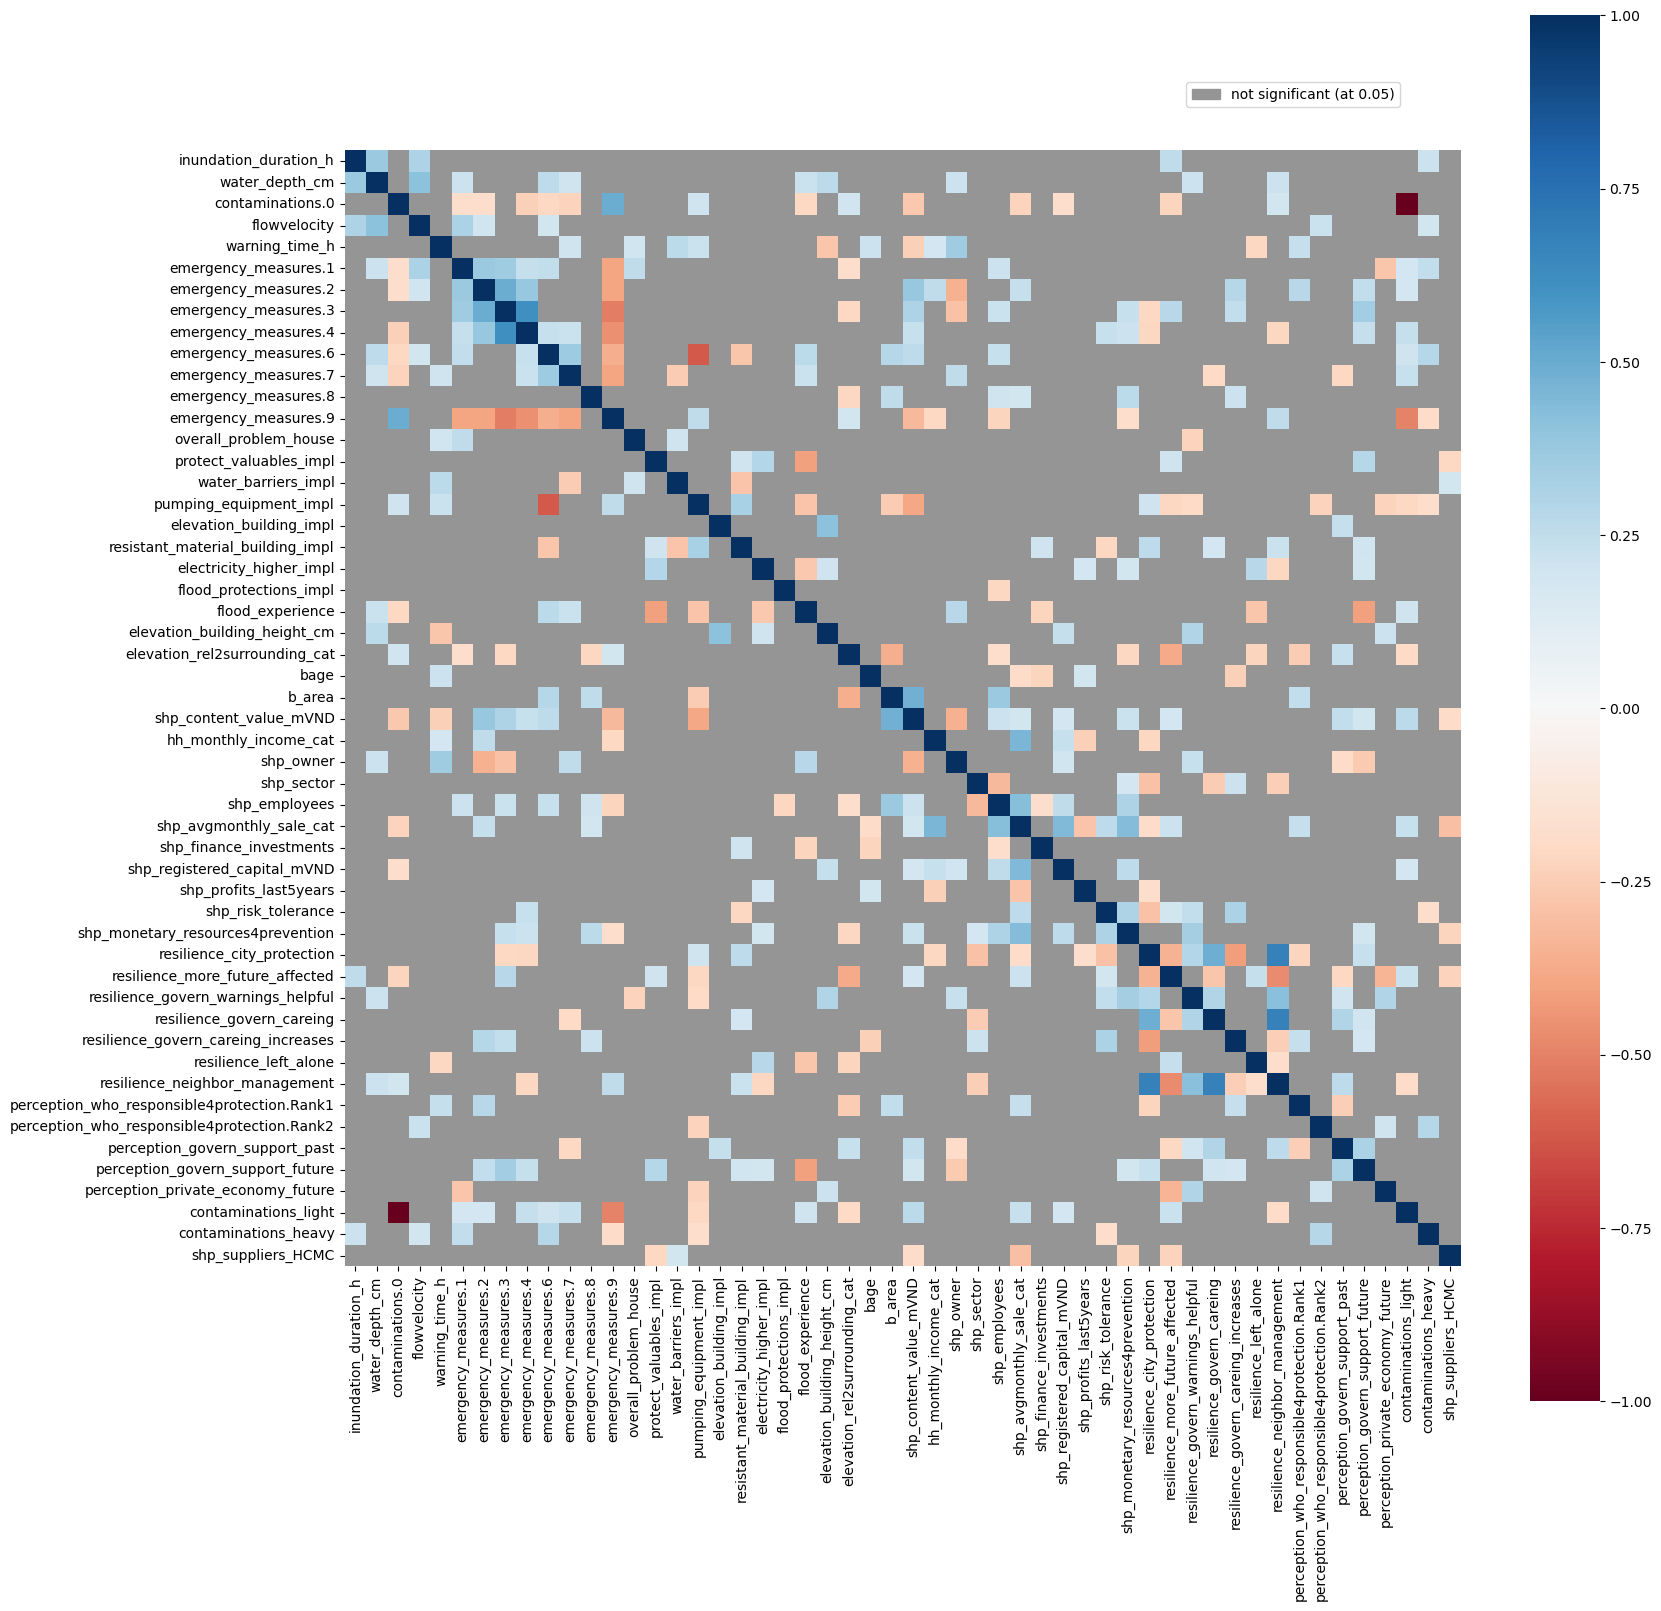

In [392]:
# import matplotlib.patches as mpatches
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy.stats import spearmanr

# def plot_spearman_rank(df_sm_corr, min_periods=100, signif=True, psig=0.05):
#         ## get the p value for pearson coefficient, subtract 1 on the diagonal
#         pvals = df_sm_corr.corr(method=lambda x, y: spearmanr(x, y)[1], min_periods=min_periods) - np.eye(*df_sm_corr.corr(method="spearman", min_periods=min_periods).shape)  # np.eye(): diagonal= ones, elsewere=zeros

#         #  main plot
#         sns.heatmap(df_sm_corr.corr(method="spearman", min_periods=min_periods), annot=False, square=True, cmap="RdBu", fmt=".2f", zorder=1)
#         # signifcance mask
#         if signif == True:
#                 ## add another heatmap with colouring the non-significant cells
#                 sns.heatmap(df_sm_corr.corr(method="spearman", min_periods=min_periods)[pvals>=psig], 
#                             annot=False, square=True, cbar=False,
#                             ## add-ons
#                             cmap=sns.color_palette("Greys", n_colors=1, desat=1),  
#                             zorder = 2) # put the map above the heatmap
#         ## add a label for the colour
#         colors = [sns.color_palette("Greys", n_colors=1, desat=1)[0]]
#         texts = [f"not significant (at {psig})"]
#         patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
#         plt.legend(handles=patches, bbox_to_anchor=(.85, 1.05), loc='center')


plt.figure(figsize=(18,18))

import utils.utils_figures as f
f.plot_spearman_rank(X_scaled_drop_nan, min_periods=50, signif=True, psig=0.05)

##### Drop features with high collinearity

Based on the above findings from VIF and spearman correlation plot remove certain features from all_input:

In [393]:
print(all_input.shape)

all_input["contaminations_light"] = None
all_input["contaminations_heavy"] = None
all_input["shp_suppliers_HCMC"] = None
#all_input["shp_suppliers_outside"] = None

# group contamination types according to their damage potential
all_input.contaminations_light = np.where( (all_input["contaminations.1"]==1) | (all_input["contaminations.4"]==1), 1, 0) # .1 = Sewage waterand excrements , .4 = Daily living garbage) 
all_input.contaminations_heavy = np.where( (all_input["contaminations.2"]==1) | (all_input["contaminations.3"]==1), 1, 0)  # .2 = fuleand oil , .3 = chemicals

## group suppliers location by their geographic location - inside or outside HCMC
## 1 - have at least one supplier inside HCMC , 0 - have all suppliers outside HCMC / non supplier in HCMC
all_input.shp_suppliers_HCMC = np.where( (all_input["shp_suppliers_location.1"]==1) | (all_input["shp_suppliers_location.2"]==1), 1, 0)  # .1 Same district, .2 in HCMC
#all_input.shp_suppliers_outside = np.where( (all_input["shp_suppliers_location.3"]==1) | (all_input["shp_suppliers_location.4"]==1) | (all_input["shp_suppliers_location.5"]==1), 1, 0) #
# 3.	Another province in the South, 4.	Another province in the North & Center, 5.	Another country in Asia 

all_input = all_input.drop(["shp_suppliers_location.1", "shp_suppliers_location.2", "shp_suppliers_location.3",
            "shp_suppliers_location.4", "shp_suppliers_location.5",
            "contaminations.1", "contaminations.4", 
            "contaminations.2", "contaminations.3",
            ], axis=1)
print(all_input.shape)


(397, 60)
(397, 54)


## Unify monetary values

In [394]:
## check for very small registered capital
vars_money = all_input.filter(regex="_mVND", axis=1)
vars_money[vars_money.shp_registered_capital_mVND <=1.0]  # less than 40 euros


,shp_content_value_mVND,Target_contentloss_mVND,shp_registered_capital_mVND
4,450.0,0.0,1.0
139,150.0,0.0,1.0
216,150.0,0.0,1.0


*list of all monetary vars*

- b_value_mVND	- price level for 2020 (year when survey was done)
- shp_building_value_mVND	- price level for 2020
- shp_content_value_mVND	- price level for 2020
- Target_contentloss_mVND	- price levels based on flood time
- shp_registered_capital_mVND  - price level for 2020
- hh_monthly_income_cat     - categircal [value ranges in mVND], # price level for 2020
- shp_avgmonthly_sale_cat   - categorical [value ranges in mVND], # price level for 2020

keep categorical monetary variables unchanged (hh_monthly_income_cat, shp_avgmonthly_sale_cat) [in mVND]
All other vars are inlfation corrected based on flood time or when survey was done 
cpi_2020 = 168.8    ,  2020 = year when the survey was done



In [395]:
## covnert all columns with million VND to VND

vars_money = np.where( (vars_money.values != np.nan),
            vars_money.values * 1000000, # convert to VND
            vars_money.values)

## rename columns
new_cols = all_input.filter(regex="_mVND", axis=1).columns.str.replace("_mVND", "_VND")
vars_money = pd.DataFrame(vars_money, columns=new_cols)


*Conversion of VND to euro (or US$)*

Based on JRC, p.8 and Paprotny2018, eg.p245
The reported damage values have been converted to Euro using the the exchange rate for the year 2020 (mean annual value)

*Source:* 
- www.oanda.com/currency/historical-rates
-  www.ecb.europa.eu/stats/exchange/eurofxref/html/eurofxref-graph-idr.en.html


In [396]:
price_index_year_of_issue = {
    2011: 121.41,
    2012: 132.44,
    2013: 137.78,
    2014: 142.88,
    2015: 140.43,
    2016: 142.98,
    2017: 149.22,
    2018: 154.63,
    2019: 158.38,
    2020: 160.70
}

price_index_2020 = 160.70
price_index_year = data_ip2["flood_year"].astype("Int64").map(price_index_year_of_issue)  # series of cpi for each year of flood event

exchange_rate = 1 / 27155  #  dong-> euro in 2020 
## (based on eurostat: https://ec.europa.eu/eurostat/databrowser/view/ERT_BIL_EUR_A/default/line?lang=en )

*Inflation correction via GDP-deflator*


\begin{equation}
\begin{align*}

&uninflated_{2020} = losses_y * exchangerate_{2020} \\
&inflationrate = uninflated_{2020} * pindex_{2020} / pindex_y\\

\end{align*}
\end{equation}

where:
- losses_y : losses in VND for year y
- uninflated_{2020} : uninflated losses in euro for 2020
- exchangerate_{2020} : exchang erate for VND to euro in year 20202 
- pindex_{2020} : price index from GDP-deflator for 2020 
- pindex_y : price index from GDP-deflator in year y

Given that inflation is the percentage change in the overall price of an item in an economy, we can use the GDP deflator to calculate the inflation rate since its a measure of the price level.


*Further sources*
Paprotny 2018: also used country-level GDP deflators for adjusting nomnal to real losses in 2011 prices , p153, p244
Sairam et al. 2020


In [397]:
#vars_money[c].apply(pd.to_numeric)#.isna()


In [398]:
## GDP-deflator

vars_money["Target_contentloss_VND_gdp"] = None

##  only direct losses needs inflation correction in respect to flood time
for r in range(len(vars_money.Target_contentloss_VND)):

    ## exchange rate: convert VND in certain year to € in the same year
    uninflated_losses = (vars_money.Target_contentloss_VND[r] * exchange_rate) # get uninflated losses in euros for year 2020

    ## price index from GDP-deflator
    vars_money["Target_contentloss_VND_gdp"][r] = round(uninflated_losses * price_index_2020 / price_index_year[r], 1)



# ##  for all other monetary continous vars: only need exchange conversion
for c in vars_money.drop(["Target_contentloss_VND_gdp","Target_contentloss_VND"], axis=1).columns:
    vars_money[c] = vars_money[c].apply(pd.to_numeric)
    for r in range(len(vars_money[c])):
        ## convert VND_2020 to €_2020
        vars_money[c][r] = round((vars_money[c][r] * exchange_rate), 1)#.astype(int)


## rename columns
new_cols = vars_money.filter(regex="_VND", axis=1).columns.str.replace("_VND", "_euro")
vars_money.columns = new_cols


In [399]:
# update all_input with unified and inflated currencies
all_input.drop(all_input.filter(regex="_mVND", axis=1).columns, axis=1, inplace=True) 
all_input = pd.concat([all_input, vars_money], axis=1)
all_input.filter(regex="euro", axis=1).columns


Index(['shp_content_value_euro', 'Target_contentloss_euro',
       'shp_registered_capital_euro', 'Target_contentloss_euro_gdp'],
      dtype='object')

## Create single datasets for each response
Select candiate predictors in respect to the response variables: Split dataset into two parts, one with candidate predictors for content losses and one dataset with candidate predictors for business reduction. This means non relevant candidate predictors fo the respective response are moved.

In [400]:
all_input.drop("Target_contentloss_euro", axis=1, inplace=True)
all_input = all_input.rename(columns={"Target_contentloss_euro_gdp": "Target_contentloss_euro"})

In [401]:
all_input_contentloss = all_input
all_input_contentloss = all_input_contentloss.drop(
    ["Target_businessreduction",
    "perception_private_economy_future",
    "shp_suppliers_HCMC",
    "shp_profits_last5years",
    #"perception_who_responsible4protection*",
    "resilience_govern_warnings_helpful",
    "resilience_more_future_affected",
    "resilience_govern_careing"
    ]
    , axis=1)
all_input_contentloss.columns



Index(['inundation_duration_h', 'water_depth_cm', 'contaminations.0',
       'flowvelocity', 'warning_time_h', 'emergency_measures.1',
       'emergency_measures.2', 'emergency_measures.3', 'emergency_measures.4',
       'emergency_measures.6', 'emergency_measures.7', 'emergency_measures.8',
       'emergency_measures.9', 'overall_problem_house',
       'protect_valuables_impl', 'water_barriers_impl',
       'pumping_equipment_impl', 'elevation_building_impl',
       'resistant_material_building_impl', 'electricity_higher_impl',
       'flood_protections_impl', 'flood_experience',
       'elevation_building_height_cm', 'elevation_rel2surrounding_cat', 'bage',
       'b_area', 'hh_monthly_income_cat', 'shp_owner', 'shp_sector',
       'shp_employees', 'shp_avgmonthly_sale_cat', 'shp_finance_investments',
       'shp_risk_tolerance', 'shp_monetary_resources4prevention',
       'resilience_city_protection', 'resilience_govern_careing_increases',
       'resilience_left_alone', 'resilience

In [402]:
all_input_business_reduction = all_input
all_input_business_reduction = all_input_business_reduction.drop(
    ["Target_contentloss_euro",
    # "perception_private_economy_future"
    # #"perception_who_responsible4protection*",
    # "resilience_govern_warnings_helpful",
    # "resilience_more_future_affected",
    # #"resilience_govern_careing"
    ],
    axis=1)

In [403]:
## get corr beween CV derived from fixed floor number or DLR based floor number
# Pearson corr: with DLR floor number : 0.76	, fixed floor number  : 0.67
# slightly higher spearman corr for Cv based on fixed number of floors (0.11) vs DLR floors (0.06)

#all_input_contentloss[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="pearson")
all_input_contentloss[["Target_contentloss_euro", "shp_content_value_euro"]].corr(method="spearman")
## --> huge difference between person and speamrn corr: due to skewed data or outliers, and that outliers are leading Pearso

,Target_contentloss_euro,shp_content_value_euro
Target_contentloss_euro,1.0,0.1
shp_content_value_euro,0.1,1.0


(0.0, 1000.0)

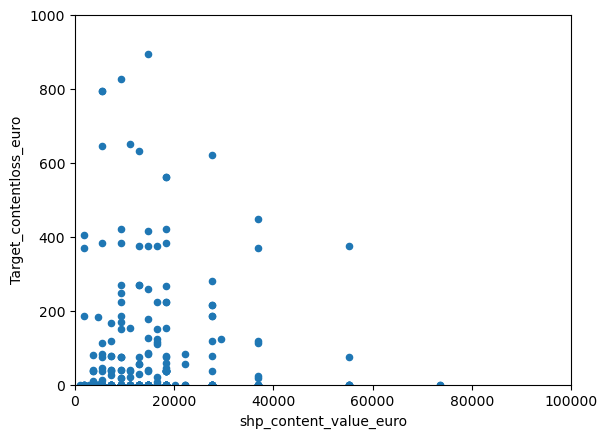

In [404]:
all_input_contentloss.plot.scatter("shp_content_value_euro", "Target_contentloss_euro")
plt.xlim(0, 100000)
plt.ylim(0, 1000)

### Content loss dataset: create new Target for relative content loss
Derive relative content loss in ratio to the estimated content value of each business

In [405]:
#print(all_input_contentloss["Target_contentloss_euro"].describe())
#print(all_input_contentloss["Target_contentloss_euro"].isna().sum())


In [406]:
all_input_contentloss["Target_relative_contentloss_euro"] =  all_input_contentloss["Target_contentloss_euro"] / all_input_contentloss["shp_content_value_euro"]
all_input_contentloss["Target_relative_contentloss_euro"].describe()

count    323.0
unique   114.0
top        0.0
freq     190.0
Name: Target_relative_contentloss_euro, dtype: float64

Set relative losses which excede content value to 1, indidcating relativ losses as high as the entire content value of the business

In [407]:
print("Records with relative content loss exceding the content values for businesses:", sum(all_input_contentloss.Target_relative_contentloss_euro >1.0) )

all_input_contentloss.Target_relative_contentloss_euro[all_input_contentloss.Target_relative_contentloss_euro > 1.0]  = 1.0
#print(all_input_contentloss[all_input_contentloss.Target_relative_contentloss_euro > 0.99 ])

Records with relative content loss exceding the content values for businesses: 2


## Test: get information about number of stories
check amount of buildings with number of stories in HCMC by utulizing ohsome API


In [408]:
import requests
#from ohsome import OhsomeClient
URL = 'https://api.ohsome.org/v1/elements/count'
data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006", "format": "json", "filter": "building=* and builing!=no and building:levels=* or level=* or building:level=* or stories=* or levels=* or building:part:levels=*"}
response = requests.post(URL, data=data)
print(response.json())

## --> building tagged in HCMC 64495.0, from those have around 2746 information about stories --> ~ <5% stories information

{'attribution': {'url': 'https://ohsome.org/copyrights', 'text': '© OpenStreetMap contributors'}, 'apiVersion': '1.9.1', 'result': [{'timestamp': '2023-07-28T19:00:00Z', 'value': 2750.0}]}


### Uncertainty of geolocations

In [409]:
glimpse = df[df.shp_employees >= 10]
glimpse.geometry.explore() 

Geolocations from the survey of the two largest businesses was compared with their actual location done by an internet search. It could be seen that the geolocations mentioned in the survey at least for the two largest businesses ahave potentially a high uncertainty range which is at least for the two examined businesses more than 200 m (beeline). The usage of spatial variables would be highly imprecise. Furthermore deriving the content value from building height is similar imprecise.


## write to disk

In [410]:
## move targets to beginning, spatial information to the end
all_input_contentloss.insert(0, "Target_contentloss_euro", all_input_contentloss.pop("Target_contentloss_euro"))
all_input_contentloss.insert(1, "Target_relative_contentloss_euro", all_input_contentloss.pop("Target_relative_contentloss_euro"))

all_input_business_reduction.insert(0, "Target_businessreduction", all_input_business_reduction.pop("Target_businessreduction"))

#all_input.insert(len(all_input.columns)-1, "geometry", all_input.pop("geometry"))
#all_input.insert(len(all_input.columns)-2, "elevation_m", all_input.pop("elevation_m"))
all_input.shape


(397, 54)

In [412]:
## save to disk
all_input_contentloss.to_excel("../../input_survey_data/input_data_contentloss.xlsx", index=False)
all_input_business_reduction.to_excel("../../input_survey_data/input_data_businessreduction.xlsx", index=False)

In [415]:
print("Content loss dataset")
print("Number of candidate predictors ", all_input_contentloss.shape[1])
print("Number of cases ", all_input_contentloss.shape[0])

print("\nBusiness reduction dataset")
print("Number of candidate predictors ", all_input_business_reduction.shape[1])
print("Number of cases ", all_input_business_reduction.shape[0])

Content loss dataset
Number of candidate predictors  48
Number of cases  397

Business reduction dataset
Number of candidate predictors  53
Number of cases  397


In [417]:
## export distribution statistics 

pd.set_option('display.float_format', lambda x: '%.1f' % x)
tbl = all_input.describe().T
tbl.to_excel("../../input_survey_data/input_data_business_distrib.xlsx", index=True)
tbl.tail(10)

,count,mean,std,min,25%,50%,75%,max
perception_who_responsible4protection.Rank1,369.0,2.3,0.9,1.0,2.0,2.0,3.0,7.0
perception_who_responsible4protection.Rank2,241.0,2.3,0.9,1.0,2.0,2.0,3.0,7.0
perception_govern_support_past,245.0,1.8,1.0,1.0,1.0,1.0,3.0,3.0
perception_govern_support_future,261.0,2.3,1.0,1.0,1.0,3.0,3.0,3.0
perception_private_economy_future,371.0,2.4,0.6,1.0,2.0,2.0,3.0,3.0
contaminations_light,397.0,0.9,0.3,0.0,1.0,1.0,1.0,1.0
contaminations_heavy,397.0,0.1,0.3,0.0,0.0,0.0,0.0,1.0
shp_suppliers_HCMC,397.0,1.0,0.1,0.0,1.0,1.0,1.0,1.0
shp_content_value_euro,334.0,16042.8,15571.2,1104.8,7365.1,12889.0,18412.8,202541.0
shp_registered_capital_euro,350.0,5366.0,38688.6,36.8,368.3,1104.8,2485.7,699687.0
